# Montecarlo calculation for Lennard Jones potential

## Lennard Jones potential
$V(r)=4(\frac{1}{r^{12}}-\frac{1}{r^6})$

In [3]:
import numpy as np
import matplotlib.pyplot as plt

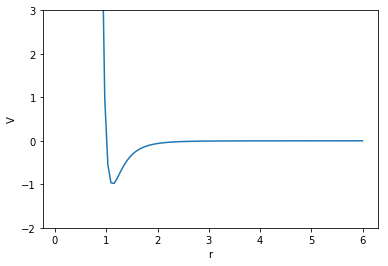

In [4]:
x=np.linspace(0,6, 100)[1:]
y=4*(1/x**12-1/x**6)

plt.plot(x,y)
plt.xlabel('r')
plt.ylabel('V')
plt.ylim(-2, 3)
plt.show()

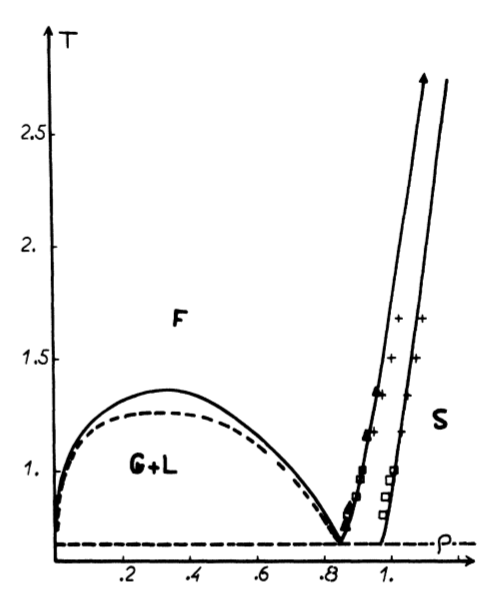

In [5]:
from IPython.display import Image
Image("phasediag.png")

## Utilities

In [6]:
dt = np.dtype([('BETA', np.float64), ('MCTIME', np.float64), ('VIRIAL1', np.float64), ('DELTA', np.float64),
               ('ENERGY', np.float64), ('N1', np.int32), ('L', np.float64), ('ACCEPTANCE', np.float64),
               ('ENERGYSQUARE', np.float64), ('TEMPERATURE', np.float64), ('DENSITY', np.float64),
               ('PRESSURE', np.float64),('CV', np.float64), ('ENERGYERR', np.float64), ('CVERR', np.float64),
               ('N', np.int32), ('THERMTIME', np.int32), ('THBIN', np.int32), ('BTIME', np.int32),
               ('VOLUME', np.float64), ('PRERR', np.float64), ('ENERGYTAIL', np.float64), ('VIRTAIL', np.float64),
               ('CUTOFF', np.float64), ('U', np.float64), ('TOTENERGY', np.float64), ('DELTAIN', np.float64),
               ('FILENAME', np.unicode_, 32), ('SIMTIME', np.float64), ('CORRTIME', np.float64)])
print(dt.fields.keys())

dict_keys(['BETA', 'MCTIME', 'VIRIAL1', 'DELTA', 'ENERGY', 'N1', 'L', 'ACCEPTANCE', 'ENERGYSQUARE', 'TEMPERATURE', 'DENSITY', 'PRESSURE', 'CV', 'ENERGYERR', 'CVERR', 'N', 'THERMTIME', 'THBIN', 'BTIME', 'VOLUME', 'PRERR', 'ENERGYTAIL', 'VIRTAIL', 'CUTOFF', 'U', 'TOTENERGY', 'DELTAIN', 'FILENAME', 'SIMTIME', 'CORRTIME'])


In [7]:
import re
import glob

# Read commented lines of the format '# NAME value' and return a structured array
def get_data(file):
    d = np.zeros([], dtype=dt)
    with open(file) as f:
        for line in f:
            try:
                m = re.match("# (\S+) ([-+]?\d+.\d+e[+-]?\d+)", line)
                d[m.group(1)]=float(m.group(2))
            except:
                try:
                    m = re.match("# (\S+) ([-+]?\d+.\d+)", line)
                    d[m.group(1)]=float(m.group(2))
                except:
                    try:
                        m = re.match("# (\S+) (\d+)", line)
                        d[m.group(1)]=int(m.group(2))
                    except: pass
    return d    

In [28]:
def deltaf(rho, T):
    delta = 0.12+0.01*T-0.1*rho
    if delta>0.02: return delta
    else: return 0.02

In [8]:
def binjk(arra, binning):
    binnum=int(len(arra)/binning)
    red_arr = np.reshape(arra, (binning, binnum), order='F').mean(axis=0)
    jk= (np.sum(red_arr**2)-red_arr**2)/binnum/(binnum-2)-(np.sum(red_arr)-red_arr)**2/binnum/(binnum-1)/(binnum-2)
    return np.mean(jk), np.sqrt(np.var(jk)*(binnum-1))

def bincvjk(ens, en, binning):
    binnum=int(len(ens)/binning)
    red_en = np.reshape(en, (binning, binnum), order='F').mean(axis=0)
    red_ens = np.reshape(ens, (binning, binnum), order='F').mean(axis=0)
    cvjk = (np.sum(red_ens)-red_ens)/(binnum-1)+(np.sum(red_en**2)-red_en**2)/(binnum*(binnum-1)*(binnum-2))\
    -(np.sum(red_en)-red_en)**2/(binnum*(binnum-2))
    return np.var(cvjk)*(binnum-1)

npbintec=np.vectorize(binjk, signature='(n),()->(),()')
npbincvjk=np.vectorize(bincvjk, signature='(n),(n),()->()')

In [9]:
seqlen=12
exclen=3

def get_satval(values, errors):
    chisq=100
    i=-1
    weights=1/errors**2
    while chisq>seqlen-1: 
        if i>len(values)-seqlen: return np.nan, np.nan, np.nan
        else:
            i+=1
            avg=np.average(values[i:i+seqlen], weights=weights[i:i+seqlen])
            chisq=np.sum((values[i:i+seqlen]-avg)**2*weights[i:i+seqlen])
    avg=np.average(values[i+exclen:i+seqlen], weights=weights[i+exclen:i+seqlen], returned=True)
    return avg[0], 1/np.sqrt(avg[1]), i        

In [10]:
def get_mcdata(file):
    d=get_data(file)
    arr=np.genfromtxt(file, usemask=True, delimiter='\t')
    indmax=int(2*d['THERMTIME']/d['THBIN'])
    energyth, virth, rhokth = np.transpose(arr[:indmax])
    energybin, ensqbin, virbin =np.transpose(arr[indmax:])
    d['ENERGY'] = np.mean(energybin)
    d['VIRIAL1'] = np.mean(virbin)
    d['ENERGYSQUARE'] = np.mean(ensqbin)
    d['TEMPERATURE']=1/d['BETA']
    d['VOLUME']=d['L']**3
    d['N']=d['N1']**3
    d['DENSITY'] = (d['N1']/d['L'])**3
    d['CUTOFF']=d['L']/2
    d['ENERGYTAIL']=(8*np.pi/3)*d['DENSITY']*(d['CUTOFF']**(-9)/3-d['CUTOFF']**(-3))
    d['VIRTAIL']=(16*np.pi/3)*d['DENSITY']*(2*d['CUTOFF']**(-9)/3-d['CUTOFF']**(-3))
    d['PRESSURE']=(d['TEMPERATURE']+d['VIRIAL1']+d['VIRTAIL'])*d['DENSITY']
    d['U']=d['ENERGY']+d['ENERGYTAIL']
    d['TOTENERGY']=d['U']+1.5*d['TEMPERATURE']
    d['CV']=d['BETA']**2*(d['ENERGYSQUARE']-d['ENERGY']**2)
    d['FILENAME']=file
    
    bins = np.array([i for i in range(1,70) if int(d['MCTIME']/d['BTIME'])%i==0])
    resen=npbintec(energybin, bins)
    respr=npbintec(virbin, bins)
    reses=npbintec(ensqbin, bins)
    rescv=npbincvjk(ensqbin, energybin, bins)
    
    s_en=get_satval(resen[0], resen[1])
    d['ENERGYERR']=np.sqrt(s_en[0])

    s_pr=get_satval(respr[0], respr[1])
    d['PRERR']=np.sqrt(s_pr[0])
    
    if not np.isnan(s_en[2]):
        i=int(s_en[2])
        vec=rescv[i+exclen : i+seqlen]
        d['CVERR']=d['BETA']**2*np.sqrt(np.average(rescv[i+exclen : i+seqlen], \
               weights=1/(resen[1][i+exclen:i+seqlen])**2))
    else: d['CVERR']=np.nan
    d['CORRTIME']=d['ENERGYERR']**2*d['MCTIME']*d['BETA']**2/d['CV']
    return d

In [11]:
def trap_area(x, y):
    return np.sum((y[1:]+y[:-1])*(x[1:]-x[:-1])/2)

def maxwell_func(Parr, Varr, P, T):
    index=np.argmax(Parr<P)
    V0=(Varr[index-1]-Varr[index])*(P-Parr[index])/(Parr[index-1]-Parr[index])+Varr[index]
    if Parr[-1]<P:
        rind=np.where(Parr>P)[0][-1]
        Vlast=(Varr[rind+1]-Varr[rind])*(P-Parr[rind])/(Parr[rind+1]-Parr[rind])+Varr[rind]
        newP=np.append(P, np.append(Parr[index:rind+1], P))
        newV=np.append(V0, np.append(Varr[index:rind+1], Vlast))
        return trap_area(newV, newP-P), V0, Vlast
    else:
        newP=np.append(P, Parr[index:])
        newV=np.append(V0, Varr[index:])
        return trap_area(newV, newP-P)+T*np.log(T/P/Varr[-1])-T+P*Varr[-1], V0, T/P

def maxwell_construction(P, V, T):
    Pmax=np.amax(P)
    Pmin=max(np.amin(P),0)
    Pfl=np.flip(P,0)
    Vfl=np.flip(V,0)
    while Pmax-Pmin>0.00001:
        Ptest=(Pmax+Pmin)/2
        res=maxwell_func(Pfl, Vfl, Ptest, T)
        if res[0]>0: Pmin=Ptest
        else: Pmax=Ptest
    return Ptest, res[1], res[2]
    

## Phase diagram

In [68]:
dataset1=np.empty(0, dtype=dt)

for file in np.roll(np.sort(glob.glob('./data/phasediag2/*.out')),16):
    d=get_mcdata(file)
    dataset1=np.append(dataset1, d)

dataset2=np.empty(0, dtype=dt)

for file in np.roll(np.sort(glob.glob('./data/phasediag3/*.out')),16):
    d=get_mcdata(file)
    dataset2=np.append(dataset2, d)
    
datasets=[dataset1, dataset2]

In [69]:
fileres = open('./data/phasediag2/resnew.dat','w') 
fileres.write('# ')
for name in dt.names: fileres.write(name+' ') 
fileres.write('\n')
for index, i in enumerate(dataset1):
    for j in i:
        fileres.write(str(j)+' ')
    fileres.write('\n')   
fileres.close()

fileres = open('./data/phasediag3/resnew.dat','w') 
fileres.write('# ')
for name in dt.names: fileres.write(name+' ') 
fileres.write('\n')
for index, i in enumerate(dataset2):
    for j in i:
        fileres.write(str(j)+' ')
    fileres.write('\n')   
fileres.close()

In [70]:
ds1=np.genfromtxt('./data/phasediag2/resnew.dat', dtype=dt, names=True)
ds2=np.genfromtxt('./data/phasediag3/resnew.dat', dtype=dt, names=True)

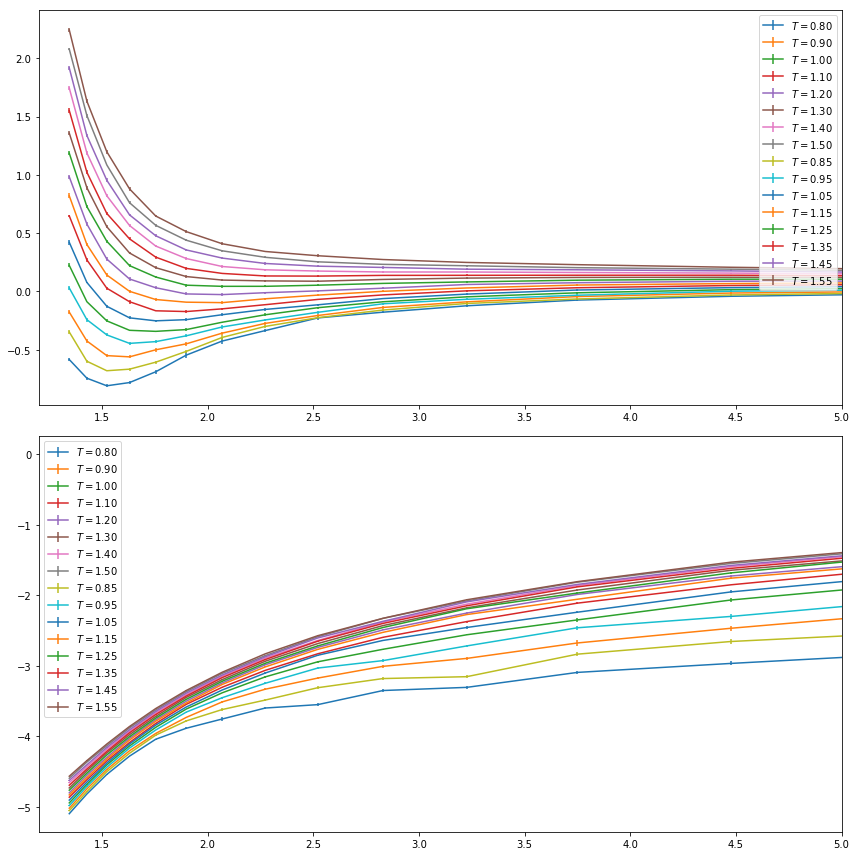

In [92]:
fpv, axarrpv = plt.subplots(2,1,figsize=(12,12))

phaseseplist=[]

for dataset in [ds1,ds2]:
    myds=dataset.view().reshape((19,8))
    

    for i in range(8):
        T=myds[0, i]['TEMPERATURE']
        axarrpv[0].errorbar(1/myds[:, i]['DENSITY'], myds[:, i]['PRESSURE'], yerr=myds[:, i]['PRERR'], label= r'$T=$%.2f' % T)
        #axarrpv[0].plot(1/myds[:, i]['DENSITY'][1:], myds[:,i]['DENSITY'][1:]*T, linestyle='dashed', label= r'$T=$%.2f' % T)
        #axarrpv[1].plot(1/myds[:,i]['DENSITY'], myds[:, i]['CV'], label= r'$T=$%.2f' % myds[0,i]['TEMPERATURE'])
        axarrpv[1].errorbar(1/myds[:, i]['DENSITY'], myds[:,i]['ENERGY'], yerr=myds[:, i]['ENERGYERR'], label= r'$T=$%.2f' % T)
        #axarrpv[1].errorbar(1/myds[:, i]['DENSITY'], myds[:,i]['CV']/myds[:,i]['ENERGYERR']**2/myds[:,i]['MCTIME']
        #                    , yerr=myds[:, i]['CVERR']/myds[:,i]['ENERGYERR']**2/myds[:,i]['MCTIME'], label= r'$T=$%.2f' % T)
        #axarrpv[1].errorbar(1/myds[:, i]['DENSITY'], 1/(myds[:,i]['CV']/myds[:,i]['ENERGYERR']**2/myds[:,i]['MCTIME'])
        #                    , label= r'$T=$%.2f' % T)
        #if i==4: print(myds[:,i]['TEMPERATURE'], 1/myds[:,i]['DENSITY'], myds[:,i]['FILENAME'], myds[:,i]['CORRTIME']/myds[:,i]['MCTIME'])
        #print(T)
        
        P0,Vl,Vr=maxwell_construction(myds[:, i]['PRESSURE'][1:], 1/myds[:, i]['DENSITY'][1:], T)
        #axarrpv[0].axhline(y=P0)
        phaseseplist.append(np.array([T, P0, 1/Vr, 1/Vl]))
phasesep=np.array(phaseseplist)
    
for ax in axarrpv:
    ax.legend()
    ax.set_xlim(xmin=1.2, xmax=5)
    #ax.set_ylim((0,0.05))
plt.tight_layout()

plt.show()

In [80]:
jtab=np.loadtxt('./JohnsonData.txt', unpack=True)

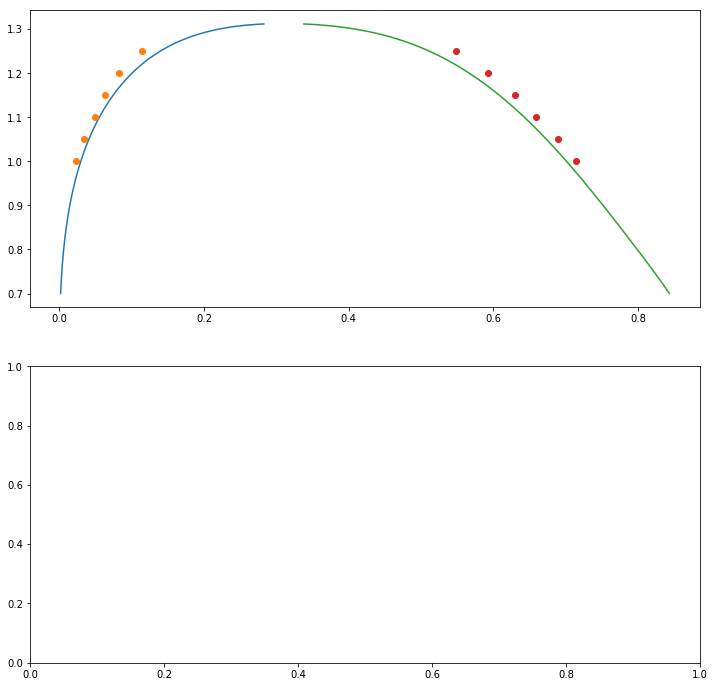

In [81]:
fpd, axarrpd = plt.subplots(2,1,figsize=(12,12))

ps=phasesep[[2,3,4,10,11,12]]

axarrpd[0].plot(jtab[1], jtab[0])
axarrpd[0].plot(ps[:,2], ps[:,0], marker='o', linestyle='')
axarrpd[0].plot(jtab[2], jtab[0])
axarrpd[0].plot(ps[:,3], ps[:,0], marker='o', linestyle='')

plt.show()

## Size scaling

In [ ]:
counter=8

rho=0.5
beta=0.5
def deltaf(rho, T):
    delta = 0.12+0.01*T-0.1*rho
    if delta>0.02: return delta
    else: return 0.02

for N1 in [13,14]:
    L1= rho**(-1/3)*N1
    delta = deltaf(rho,1/beta)
    file = open('./data/size_scaling/test%04d.in' % counter,'w') 
    file.write("N1      %d\nL       %.8f\nDELTAIN %.4f\nBETA    %.8f\nMCTIME  3600000\
    \nBTIME   10000\nTHBIN   50\n" % (N1, L1, delta, beta))
    file.close()
    counter+=1

In [103]:
dataset=np.empty(0, dtype=dt)

for file in glob.glob('./data/size_scaling/*.out'):
    d=get_mcdata(file)
    dataset=np.append(dataset, d)



In [104]:
print(dataset['SIMTIME'])

[  22.   38.   59.   82.  117.  165.  206.  263.  332.  399.   35.   88.
   56.]


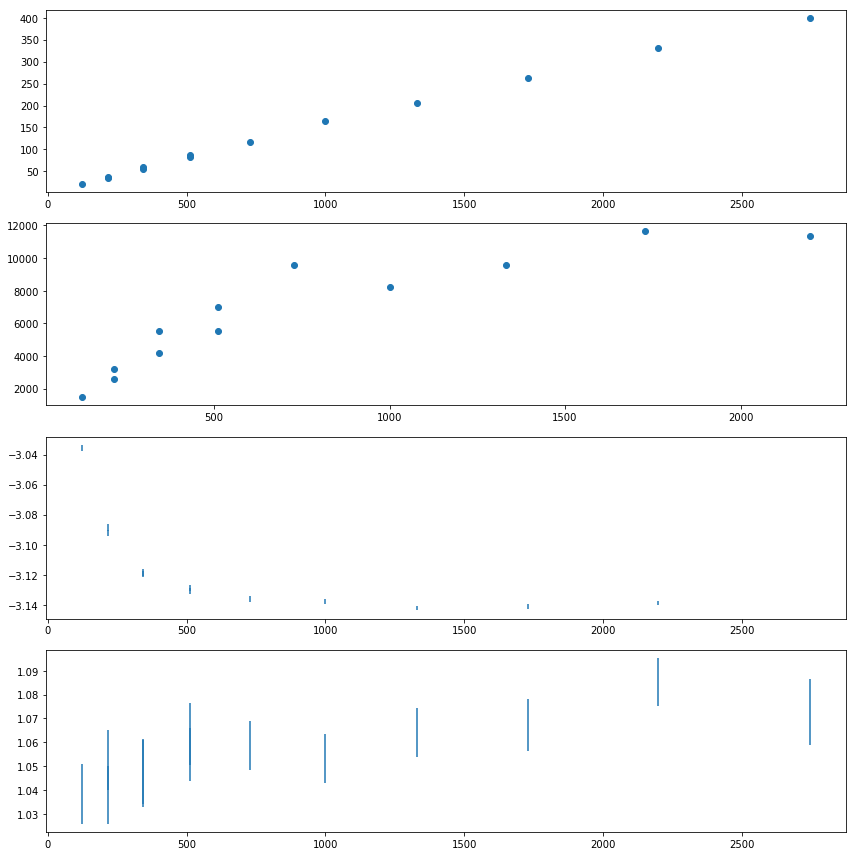

In [107]:
f, axarr = plt.subplots(4,1,figsize=(12,12))

axarr[0].plot(dataset['N'], dataset['SIMTIME'], marker='o', linestyle='')
axarr[1].plot(dataset['N'], dataset['CORRTIME'], marker='o', linestyle='')
axarr[2].errorbar(dataset['N'], dataset['ENERGY'], yerr=dataset['ENERGYERR'], linestyle='')
axarr[3].errorbar(dataset['N'], dataset['PRESSURE'], yerr=dataset['PRERR'], linestyle='')
plt.tight_layout()

plt.show()

## Read data

In [ ]:
file = './data/size_scaling/test1.out'
d=get_data(file)
arr=np.genfromtxt(file, usemask=True, delimiter='\t')
indmax=int(2*d['THERMTIME']/d['THBIN'])
energyth, virth, rhokth = np.transpose(arr[:indmax])
energybin, ensqbin, virbin =np.transpose(arr[indmax:])
d['ENERGY'] = np.mean(energybin)
d['VIRIAL1'] = np.mean(virbin)
d['ENERGYSQUARE'] = np.mean(ensqbin)
d['TEMPERATURE']=1/d['BETA']
d['VOLUME']=d['L']**3
d['N']=d['N1']**3
d['DENSITY'] = (d['N1']/d['L'])**3
d['CUTOFF']=d['L']/2
d['ENERGYTAIL']=(8*np.pi/3)*d['DENSITY']*(d['CUTOFF']**(-9)/3-d['CUTOFF']**(-3))
d['VIRTAIL']=(16*np.pi/3)*d['DENSITY']*(2*d['CUTOFF']**(-9)/3-d['CUTOFF']**(-3))
d['PRESSURE']=(d['TEMPERATURE']+d['VIRIAL1']+d['VIRTAIL'])*d['DENSITY']
d['U']=d['ENERGY']+d['ENERGYTAIL']
d['TOTENERGY']=d['U']+1.5*d['TEMPERATURE']
d['CV']=d['BETA']**2*(d['ENERGYSQUARE']-d['ENERGY']**2)
d['FILENAME']=file
for name in d.dtype.names: print(name, d[name])

## Equilibration time

In [ ]:
f, axarr = plt.subplots(1,2,figsize=(12,4))

#for file in glob.glob('./data/*.out'):
axarr[0].plot(d['THBIN']*np.arange(len(rhokth)),energyth, label = r'$\beta=$%.2f' % d['BETA'])
axarr[1].plot(d['THBIN']*np.arange(len(rhokth)),rhokth, label = r'$\beta=$%.2f' % d['BETA'])

axarr[0].set_xlabel('Time')
axarr[0].set_ylabel('Energy')
axarr[1].set_xlabel('Time')
axarr[1].set_ylabel(r'$\rho_k$')
print(d)
    
handles, labels = axarr[1].get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
axarr[1].legend(handles, labels)
plt.show()

## Error bars

### Block technique for sample averages
Block technique: we divide the simulation (total number of steps $N_{steps}$) into $k$ blocks of length $t_B$ ($N_{steps}=k \cdot t_B$). We compute the average quantity over each bin $x_{B_i}$. The sample average of $\{x_{B_i}\}$ is $\bar{x}$, so, if the binned quantities are independent variables, the following is an estimator of the variance of $\bar{x}$

\begin{equation}
s^2=\frac{1}{k(k-1)}\sum_{i=1}^k (x_{B_j}-\bar{x})^2.
\end{equation}


When the size of the blocks is much larger than correlation time, $s^2$ approaches the constant value $\sigma^2_{\bar{x}}$.

#### Jackknife estimate of error bars for $s^2$
We apply jackknife technique to calculate the error bars for $s^2$, under the assumption that the bins are large enough to be independent: the unbiased jackknife estimator is obtained as
\begin{equation}
\theta_i^J=\frac{k\bar{x^2}-x_i^2}{k(k-2)}-\frac{(k\bar{x}-x_i)^2}{k(k-1)(k-2)}
\end{equation}

with average

\begin{equation}
\bar{\theta^J}=\frac{1}{k}\sum_i \theta_i^J =\frac{1}{k-1}(\bar{x^2}-\bar{x}^2)=s^2.
\end{equation}

The error according to jackknife technique is given by
\begin{equation}
\delta \theta^2 ={\frac{k-1}{k}\sum_i (\theta_i^J-\bar{\theta^J})^2}
\end{equation}

### Block technique and jackknife for specific heat
For each bin $B_i$ we computed the average of $E$ (we call it $g_i$) and of $E^2$ (we call it $f_i$). The specific heat is proportional to $\langle E^2 \rangle-(\langle E \rangle)^2$ so it can be estimated from
\begin{equation}
C=\bar{E^2}-\bar{E}^2=\bar{f}-\left(\bar{g}\right)^2=\frac{1}{k}\sum_{i=1}^k f_i-\left(\frac{1}{k}\sum_{i=1}^k g_i\right)^2
\end{equation}

We define the unbiased version of the Jackknife estimator
\begin{equation}
C_i^j=\frac{k\bar{f}-f_i}{k-1}+\frac{k\bar{g^2}-g_i^2}{k(k-1)(k-2)}-\frac{(k\bar{g}-g_i)^2}{k(k-2)}.
\end{equation}
It has the property that
\begin{equation}
\frac{1}{k}\sum_{i=1}^k C_i^j =\bar{C^j}=C
\end{equation}

This means that we have been able to write our estimator as the sample average of the $C_i^j$, which are independent variables if the bins are large enough. The variance of $C$ can be estimated using Jackknife technique

\begin{equation}
\delta C =\sqrt{\frac{1}{k-1}\sum_{i=1}^k (C_i^J-C)^2}
\end{equation}

We plot this value for different size of the bins until we reach convergence (size much larger than correlation time).

In [ ]:
bins = np.array([i for i in range(1,70) if int(d['MCTIME']/d['BTIME'])%i==0])

resen=npbintec(energybin, bins)
respr=npbintec(virbin, bins)
reses=npbintec(ensqbin, bins)
rescv=npbincvjk(ensqbin, energybin, bins)

In [ ]:
f, axarr = plt.subplots(1,3,figsize=(12,4))

#for file in glob.glob('./data/*.out'):
axarr[0].errorbar(bins*d['BTIME'], resen[0], marker='o', yerr=resen[1], label = r'$\beta=$%.2f' % d['BETA'])
s_en=get_satval(resen[0], resen[1])
axarr[0].axhline(y=s_en[0])
axarr[0].axhline(y=s_en[0]+s_en[1], linestyle='dashed')
axarr[0].axhline(y=s_en[0]-s_en[1], linestyle='dashed')

axarr[1].errorbar(bins*d['BTIME'], respr[0], marker='o', yerr=respr[1], label = r'$\beta=$%.2f' % d['BETA'])
s_pr=get_satval(respr[0], respr[1])
axarr[1].axhline(y=s_pr[0])
axarr[1].axhline(y=s_pr[0]+s_pr[1], linestyle='dashed')
axarr[1].axhline(y=s_pr[0]-s_pr[1], linestyle='dashed')

axarr[2].plot(bins*d['BTIME'], rescv, marker='o', label = r'$\beta=$%.2f' % d['BETA'])

axarr[0].set_xlabel('Bin size')
axarr[0].set_ylabel(r'(Energy error bar$)^2$')
axarr[1].set_xlabel('Bin size')
axarr[1].set_ylabel(r'(Virial coeff error bar$)^2$')
axarr[2].set_xlabel('Bin size')
axarr[2].set_ylabel(r'(Specific heat error bar$)^2$')

i=s_en[2]
#stravbhnbjckn=rescv[s_en[2]+exclen : s_en[2]+seqlen]
axarr[2].axhline(y=(np.average(rescv[i+exclen : i+seqlen], \
               weights=1/(resen[1][i+exclen:i+seqlen])**2)))
for ax in axarr: ax.set_ylim(ymin=0)

handles, labels = axarr[1].get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
axarr[1].legend(handles, labels)
plt.tight_layout()
plt.show()

# Analysis

In [ ]:
nictab=np.loadtxt('./nicolastab.dat', unpack=True)
N1=5

def deltaf(rho, T):
    delta = 0.12+0.01*T-0.1*rho
    if delta>0.02: return delta
    else: return 0.02

for counter, el in enumerate(zip(nictab[0], nictab[1])):
    L1= el[0]**(-1/3)*N1
    beta =1/el[1]
    delta = deltaf(*el)
    file = open('./data/nicolas_test/test%04d.in' % counter,'w') 
    file.write("N1      5\nL       %.8f\nDELTAIN %.4f\nBETA    %.8f\nMCTIME  3600000\
    \nBTIME   10000\nTHBIN   50\n" % (L1, delta, beta))
    file.close()

In [ ]:
for file in glob.glob('./data/nicolas_test/*.out')[19:20]:
    print(file)

In [ ]:
fth, axarrth = plt.subplots(1,2,figsize=(12,4))
feb, axarreb = plt.subplots(1,3,figsize=(12,4))

dataset=np.empty(0, dtype=dt)

rednictab=nictab[:,106:107]
for file in glob.glob('./data/nicolas_test/*.out')[106:107]:
    d=get_data(file)
    arr=np.genfromtxt(file, usemask=True, delimiter='\t')
    indmax=int(2*d['THERMTIME']/d['THBIN'])
    energyth, virth, rhokth = np.transpose(arr[:indmax])
    energybin, ensqbin, virbin =np.transpose(arr[indmax:])
    d['ENERGY'] = np.mean(energybin)
    d['VIRIAL1'] = np.mean(virbin)
    d['ENERGYSQUARE'] = np.mean(ensqbin)
    d['TEMPERATURE']=1/d['BETA']
    d['VOLUME']=d['L']**3
    d['N']=d['N1']**3
    d['DENSITY'] = (d['N1']/d['L'])**3
    d['CUTOFF']=d['L']/2
    d['ENERGYTAIL']=(8*np.pi/3)*d['DENSITY']*(d['CUTOFF']**(-9)/3-d['CUTOFF']**(-3))
    d['VIRTAIL']=(16*np.pi/3)*d['DENSITY']*(2*d['CUTOFF']**(-9)/3-d['CUTOFF']**(-3))
    d['PRESSURE']=(d['TEMPERATURE']+d['VIRIAL1']+d['VIRTAIL'])*d['DENSITY']
    d['U']=d['ENERGY']+d['ENERGYTAIL']
    d['TOTENERGY']=d['U']+1.5*d['TEMPERATURE']
    d['CV']=d['BETA']**2*(d['ENERGYSQUARE']-d['ENERGY']**2)
    d['FILENAME']=file
    bins = np.array([i for i in range(1,10) if int(d['MCTIME']/d['BTIME'])%i==0])
    resen=npbintec(energybin, bins)
    respr=npbintec(virbin, bins)
    reses=npbintec(ensqbin, bins)
    rescv=npbincvjk(ensqbin, energybin, bins)
    d['ENERGYERR']=np.sqrt(np.mean(resen[0][-5:])*d['BTIME']/d['MCTIME'])
    d['PRERR']=np.sqrt(np.mean(respr[0][-5:])*d['BTIME']/d['MCTIME'])
    d['CVERR']=np.sqrt(np.mean(rescv[-5:])*d['BTIME']/d['MCTIME'])
    axarrth[0].plot(d['THBIN']*np.arange(len(rhokth)),energyth, label = r'$\beta=$%.2f' % d['BETA'])
    axarrth[1].plot(d['THBIN']*np.arange(len(rhokth)),rhokth, label = r'$\beta=$%.2f' % d['BETA'])
    axarreb[0].errorbar(bins*d['BTIME'], resen[0], marker='o', yerr=resen[1], label = r'$\beta=$%.2f' % d['BETA'])
    axarreb[1].errorbar(bins*d['BTIME'], respr[0], marker='o', yerr=respr[1], label = r'$\beta=$%.2f' % d['BETA'])
    axarreb[2].plot(bins*d['BTIME'], rescv, marker='o', label = r'$\beta=$%.2f' % d['BETA'])
    dataset=np.append(dataset, d)
    print(d['DENSITY'], d['TEMPERATURE'], d['U'],  d['ENERGYERR'], d['CV'], d['CVERR'], d['PRESSURE'], d['PRERR'])

    
axarrth[0].set_xlabel('Time')
axarrth[0].set_ylabel('Energy')
axarrth[1].set_xlabel('Time')
axarrth[1].set_ylabel(r'$\rho_k$')
handlesth, labelsth = axarrth[1].get_legend_handles_labels()
labelsth, handlesth = zip(*sorted(zip(labelsth, handlesth), key=lambda t: t[0]))
axarrth[1].legend(handlesth, labelsth)    
    
axarreb[0].set_xlabel('Bin size')
axarreb[0].set_ylabel(r'(Energy error bar$)^2$')
axarreb[1].set_xlabel('Bin size')
axarreb[1].set_ylabel(r'(Virial coeff error bar$)^2$')   
handleseb, labelseb = axarreb[1].get_legend_handles_labels()
labelseb, handleseb = zip(*sorted(zip(labelseb, handleseb), key=lambda t: t[0]))
axarr[1].legend(handleseb, labelseb)

fupcv, axarrupcv= plt.subplots(1,3,figsize=(12,4))
axarrupcv[0].errorbar(dataset['TEMPERATURE'], dataset['U'], marker='o', yerr=dataset['ENERGYERR'], label = r'$\rho=$%.2f' % d['DENSITY'])
axarrupcv[1].errorbar(dataset['TEMPERATURE'], dataset['PRESSURE'], marker='o', yerr=dataset['PRERR'], label = r'$\rho=$%.2f' % d['DENSITY'])
axarrupcv[2].errorbar(dataset['TEMPERATURE'], dataset['CV'], marker='o', yerr=dataset['CVERR'], label = r'$\rho=$%.2f' % d['DENSITY'])
axarrupcv[0].plot(rednictab[1], rednictab[2], marker='o')
axarrupcv[1].plot(rednictab[1], rednictab[3], marker='o')

plt.tight_layout()
plt.show()

In [ ]:
fileres = open('./data/nicolas_test/results.dat','a') 
#for name in dataset[0]: fileres.write(name)
#fileres.write('# ')
#for name in dt.names: fileres.write(name+' ') 
#fileres.write('NIC_U NIC_P\n')
for index, i in enumerate(dataset):
    for j in i:
        fileres.write(str(j)+' ')
    fileres.write(str(rednictab[2,index])+' ')
    fileres.write(str(rednictab[3,index])+' ')
    fileres.write('\n')
fileres.close()

In [ ]:
#%%bash
#for i in 62 63 64 65 66 71 72 73 74 75 76 77 78 81;
#do
#echo $i
#./simulation ./data/nicolas_test/test00$i.in ./data/nicolas_test/test00$i.out
#done

In [ ]:
resdt = np.dtype([('BETA', np.float64), ('MCTIME', np.float64), ('VIRIAL1', np.float64), ('DELTA', np.float64),
               ('ENERGY', np.float64), ('N1', np.int32), ('L', np.float64), ('ACCEPTANCE', np.float64),
               ('ENERGYSQUARE', np.float64), ('TEMPERATURE', np.float64), ('DENSITY', np.float64),
               ('PRESSURE', np.float64),('CV', np.float64), ('ENERGYERR', np.float64), ('CVERR', np.float64),
               ('N', np.int32), ('THERMTIME', np.int32), ('THBIN', np.int32), ('BTIME', np.int32),
               ('VOLUME', np.float64), ('PRERR', np.float64), ('ENERGYTAIL', np.float64), ('VIRTAIL', np.float64),
               ('CUTOFF', np.float64), ('U', np.float64), ('TOTENERGY', np.float64), ('DELTAIN', np.float64),
               ('FILENAME', np.unicode_, 32), ('NIC_U', np.float64), ('NIC_P', np.float64)])

In [ ]:
results=np.genfromtxt('./data/nicolas_test/results.dat', dtype=resdt, names=True)

In [ ]:
print(results[:]['DENSITY'])


In [ ]:
fres, axarres = plt.subplots(4,3,figsize=(18,20))

cmap = plt.get_cmap('tab10')
N=10

for i, dataset in enumerate(np.split(results, [6, 12, 18, 30, 43, 56, 61, 66, 77, 83, 90, 99])[0:3]):
    color = cmap(float(i)/N)
    #print(dataset['DENSITY'])
    axarres[0][0].errorbar(dataset['TEMPERATURE'], dataset['U'], marker='o', yerr=dataset['ENERGYERR'],
                       label = r'$\rho=$%.2f' % dataset[0]['DENSITY'], color=color)
    axarres[0][1].errorbar(dataset['TEMPERATURE'], dataset['PRESSURE'], marker='o', yerr=dataset['PRERR'],
                       color=color)
    axarres[0][2].errorbar(dataset['TEMPERATURE'], dataset['CV'], marker='o', yerr=dataset['CVERR'],
                       color=color)
    axarres[0][0].plot(dataset['TEMPERATURE'], dataset['NIC_U'], marker='*', color=color, linestyle='')
    axarres[0][1].plot(dataset['TEMPERATURE'], dataset['NIC_P'], marker='*', color=color, linestyle='')


for i, dataset in enumerate(np.split(results, [6, 12, 18, 30, 43, 56, 61, 66, 77, 83, 90, 99])[3:6]):
    color = cmap(float(i)/N)
    #print(dataset['DENSITY'])
    axarres[1][0].errorbar(dataset['TEMPERATURE'], dataset['U'], marker='o', yerr=dataset['ENERGYERR'],
                       label = r'$\rho=$%.2f' % dataset[0]['DENSITY'], color=color)
    axarres[1][1].errorbar(dataset['TEMPERATURE'], dataset['PRESSURE'], marker='o', yerr=dataset['PRERR'],
                       color=color)
    axarres[1][2].errorbar(dataset['TEMPERATURE'], dataset['CV'], marker='o', yerr=dataset['CVERR'],
                       color=color)
    axarres[1][0].plot(dataset['TEMPERATURE'], dataset['NIC_U'], marker='*', color=color, linestyle='')
    axarres[1][1].plot(dataset['TEMPERATURE'], dataset['NIC_P'], marker='*', color=color, linestyle='')
    
for i, dataset in enumerate(np.split(results, [6, 12, 18, 30, 43, 56, 61, 66, 77, 83, 90, 99])[7:10]):
    color = cmap(float(i)/N)
    #print(dataset['DENSITY'])
    axarres[2][0].errorbar(dataset['TEMPERATURE'], dataset['U'], marker='o', yerr=dataset['ENERGYERR'],
                       label = r'$\rho=$%.2f' % dataset[0]['DENSITY'], color=color)
    axarres[2][1].errorbar(dataset['TEMPERATURE'], dataset['PRESSURE'], marker='o', yerr=dataset['PRERR'],
                       color=color)
    axarres[2][2].errorbar(dataset['TEMPERATURE'], dataset['CV'], marker='o', yerr=dataset['CVERR'],
                       color=color)
    axarres[2][0].plot(dataset['TEMPERATURE'], dataset['NIC_U'], marker='*', color=color, linestyle='')
    axarres[2][1].plot(dataset['TEMPERATURE'], dataset['NIC_P'], marker='*', color=color, linestyle='')
    
for i, dataset in enumerate(np.split(results, [6, 12, 18, 30, 43, 56, 61, 66, 77, 83, 90, 99])[10:]):
    color = cmap(float(i)/N)
    #print(dataset['DENSITY'])
    axarres[3][0].errorbar(dataset['TEMPERATURE'], dataset['U'], marker='o', yerr=dataset['ENERGYERR'],
                       label = r'$\rho=$%.2f' % dataset[0]['DENSITY'], color=color)
    axarres[3][1].errorbar(dataset['TEMPERATURE'], dataset['PRESSURE'], marker='o', yerr=dataset['PRERR'],
                       color=color)
    axarres[3][2].errorbar(dataset['TEMPERATURE'], dataset['CV'], marker='o', yerr=dataset['CVERR'],
                       color=color)
    axarres[3][0].plot(dataset['TEMPERATURE'], dataset['NIC_U'], marker='*', color=color, linestyle='')
    axarres[3][1].plot(dataset['TEMPERATURE'], dataset['NIC_P'], marker='*', color=color, linestyle='')
    
axarres[0][0].legend()
axarres[1][0].legend()
axarres[2][0].legend()
axarres[3][0].legend()

plt.tight_layout()
plt.show()

## Phase diagram

In [30]:
counter=144
N1=5

for rho in [0.03]:
#for rho in np.linspace(0.05, 0.74333333, 17):
#for rho in [0.74333333]:
    for T in np.linspace(0.8, 1.5, 8):
        L1= rho**(-1/3)*N1
        beta =1/T
        delta = deltaf(rho,T)
        file = open('./data/phasediag2/test%04d.in' % counter,'w') 
        file.write("N1      5\nL       %.8f\nDELTAIN %.4f\nBETA    %.8f\nMCTIME  3600000\
        \nBTIME   10000\nTHBIN   50\n" % (L1, delta, beta))
        file.close()
        counter+=1

In [ ]:
for rho in np.linspace(0.05, 0.74333333, 17): print(rho)
for rho in np.linspace(0.00666, 0.83, 20): print(rho)

In [ ]:
fth, axarrth = plt.subplots(1,2,figsize=(12,4))
feb, axarreb = plt.subplots(1,3,figsize=(12,4))

dataset=np.empty(0, dtype=dt)

for file in glob.glob('./data/phasediag3/*.out'):
    d=get_data(file)
    arr=np.genfromtxt(file, usemask=True, delimiter='\t')
    indmax=int(2*d['THERMTIME']/d['THBIN'])
    energyth, virth, rhokth = np.transpose(arr[:indmax])
    energybin, ensqbin, virbin =np.transpose(arr[indmax:])
    d['ENERGY'] = np.mean(energybin)
    d['VIRIAL1'] = np.mean(virbin)
    d['ENERGYSQUARE'] = np.mean(ensqbin)
    d['TEMPERATURE']=1/d['BETA']
    d['VOLUME']=d['L']**3
    d['N']=d['N1']**3
    d['DENSITY'] = (d['N1']/d['L'])**3
    d['CUTOFF']=d['L']/2
    d['ENERGYTAIL']=(8*np.pi/3)*d['DENSITY']*(d['CUTOFF']**(-9)/3-d['CUTOFF']**(-3))
    d['VIRTAIL']=(16*np.pi/3)*d['DENSITY']*(2*d['CUTOFF']**(-9)/3-d['CUTOFF']**(-3))
    d['PRESSURE']=(d['TEMPERATURE']+d['VIRIAL1']+d['VIRTAIL'])*d['DENSITY']
    d['U']=d['ENERGY']+d['ENERGYTAIL']
    d['TOTENERGY']=d['U']+1.5*d['TEMPERATURE']
    d['CV']=d['BETA']**2*(d['ENERGYSQUARE']-d['ENERGY']**2)
    d['FILENAME']=file
    bins = np.array([i for i in range(1,90) if int(d['MCTIME']/d['BTIME'])%i==0])
    resen=npbintec(energybin, bins)
    respr=npbintec(virbin, bins)
    reses=npbintec(ensqbin, bins)
    rescv=npbincvjk(ensqbin, energybin, bins)
    d['ENERGYERR']=np.sqrt(np.mean(resen[0][-5:])*d['BTIME']/d['MCTIME'])
    d['PRERR']=np.sqrt(np.mean(respr[0][-5:])*d['BTIME']/d['MCTIME'])
    d['CVERR']=np.sqrt(np.mean(rescv[-5:])*d['BTIME']/d['MCTIME'])
    #axarrth[0].plot(d['THBIN']*np.arange(len(rhokth)),energyth, label = r'$\beta=$%.2f' % d['BETA'])
    #axarrth[1].plot(d['THBIN']*np.arange(len(rhokth)),rhokth, label = r'$\beta=$%.2f' % d['BETA'])
    #axarreb[0].errorbar(bins*d['BTIME'], resen[0], marker='o', yerr=resen[1], label = r'$\beta=$%.2f' % d['BETA'])
    #axarreb[1].errorbar(bins*d['BTIME'], respr[0], marker='o', yerr=respr[1], label = r'$\beta=$%.2f' % d['BETA'])
    #axarreb[2].plot(bins*d['BTIME'], rescv, marker='o', label = r'$\beta=$%.2f' % d['BETA'])
    dataset=np.append(dataset, d)
    print(d['DENSITY'], d['TEMPERATURE'], d['U'],  d['ENERGYERR'], d['CV'], d['CVERR'], d['PRESSURE'], d['PRERR'])

#myds=dataset.view().reshape((16,8))
#print(myds.shape)
    
axarrth[0].set_xlabel('Time')
axarrth[0].set_ylabel('Energy')
axarrth[1].set_xlabel('Time')
axarrth[1].set_ylabel(r'$\rho_k$')
handlesth, labelsth = axarrth[1].get_legend_handles_labels()
labelsth, handlesth = zip(*sorted(zip(labelsth, handlesth), key=lambda t: t[0]))
axarrth[1].legend(handlesth, labelsth)    
    
axarreb[0].set_xlabel('Bin size')
axarreb[0].set_ylabel(r'(Energy error bar$)^2$')
axarreb[1].set_xlabel('Bin size')
axarreb[1].set_ylabel(r'(Virial coeff error bar$)^2$')   
handleseb, labelseb = axarreb[1].get_legend_handles_labels()
labelseb, handleseb = zip(*sorted(zip(labelseb, handleseb), key=lambda t: t[0]))
axarr[1].legend(handleseb, labelseb)

fupcv, axarrupcv= plt.subplots(1,3,figsize=(12,4))
axarrupcv[0].errorbar(dataset['TEMPERATURE'], dataset['U'], marker='o', yerr=dataset['ENERGYERR'], label = r'$\rho=$%.2f' % d['DENSITY'])
axarrupcv[1].errorbar(dataset['TEMPERATURE'], dataset['PRESSURE'], marker='o', yerr=dataset['PRERR'], label = r'$\rho=$%.2f' % d['DENSITY'])
axarrupcv[2].errorbar(dataset['TEMPERATURE'], dataset['CV'], marker='o', yerr=dataset['CVERR'], label = r'$\rho=$%.2f' % d['DENSITY'])

plt.tight_layout()
plt.show()

In [ ]:
fileres = open('./data/phasediag3/results.dat','a') 
fileres.write('# ')
for name in dt.names: fileres.write(name+' ') 
for index, i in enumerate(dataset):
    for j in i:
        fileres.write(str(j)+' ')
    fileres.write('\n')
fileres.close()

In [ ]:
phasediagramnew=np.genfromtxt('./data/phasediag3/results.dat', dtype=dt, names=True)

mydsnew=phasediagramnew.view().reshape((17,8))
print(mydsnew.shape)

In [ ]:
def trap_area(x, y):
    return np.sum((y[1:]+y[:-1])*(x[1:]-x[:-1])/2)

def maxwell_func(Parr, Varr, P, T):
    index=np.argmax(Parr<P)
    V0=(Varr[index-1]-Varr[index])*(P-Parr[index])/(Parr[index-1]-Parr[index])+Varr[index]
    if Parr[-1]<P:
        rind=np.where(Parr>P)[0][-1]
        Vlast=(Varr[rind+1]-Varr[rind])*(P-Parr[rind])/(Parr[rind+1]-Parr[rind])+Varr[rind]
        newP=np.append(P, np.append(Parr[index:rind+1], P))
        newV=np.append(V0, np.append(Varr[index:rind+1], Vlast))
        return trap_area(newV, newP-P), V0, Vlast
    else:
        newP=np.append(P, Parr[index:])
        newV=np.append(V0, Varr[index:])
        return trap_area(newV, newP-P)+T*np.log(T/P/Varr[-1])-T+P*Varr[-1], V0, T/P

def maxwell_construction(P, V, T):
    Pmax=np.amax(P)
    Pmin=max(np.amin(P),0)
    Pfl=np.flip(P,0)
    Vfl=np.flip(V,0)
    while Pmax-Pmin>0.00001:
        Ptest=(Pmax+Pmin)/2
        res=maxwell_func(Pfl, Vfl, Ptest, T)
        if res[0]>0: Pmin=Ptest
        else: Pmax=Ptest
    return Ptest, res[1], res[2]
    

In [ ]:
fpv, axarrpv = plt.subplots(2,1,figsize=(12,12))

phaseseplist=[]

for i in range(8):
    T=myds[0, i]['TEMPERATURE']
    axarrpv[0].errorbar(myds[:, i]['DENSITY'], myds[:, i]['PRESSURE'], yerr=myds[:, i]['PRERR'], label= r'$T=$%.2f' % T)
    #axarrpv[1].plot(1/myds[:,i]['DENSITY'], myds[:, i]['CV'], label= r'$T=$%.2f' % myds[0,i]['TEMPERATURE'])
    axarrpv[1].errorbar(1/myds[:, i]['DENSITY'], myds[:,i]['ENERGY'], yerr=myds[:, i]['ENERGYERR'], label= r'$T=$%.2f' % T)
    P0,Vl,Vr=maxwell_construction(myds[:, i]['PRESSURE'], 1/myds[:, i]['DENSITY'], T)
    #axarrpv[0].axhline(y=P0)
    phaseseplist.append(np.array([T, P0, 1/Vr, 1/Vl]))
    T=mydsnew[0, i]['TEMPERATURE']
    axarrpv[0].errorbar(1/mydsnew[:, i]['DENSITY'], mydsnew[:, i]['PRESSURE'], yerr=mydsnew[:, i]['PRERR'], label= r'$T=$%.2f' % T)
    #axarrpv[1].plot(1/myds[:,i]['DENSITY'], myds[:, i]['CV'], label= r'$T=$%.2f' % myds[0,i]['TEMPERATURE'])
    axarrpv[1].errorbar(1/mydsnew[:, i]['DENSITY'], myds[:,i]['ENERGY'], yerr=mydsnew[:, i]['ENERGYERR'], label= r'$T=$%.2f' % T)
    P0,Vl,Vr=maxwell_construction(mydsnew[:, i]['PRESSURE'], 1/mydsnew[:, i]['DENSITY'], T)
    #axarrpv[0].axhline(y=P0)
    phaseseplist.append(np.array([T, P0, 1/Vr, 1/Vl]))
    
phasesep=np.array(phaseseplist)
    
for ax in axarrpv:
    ax.legend()
    #ax.set_xlim(xmax=5)
    #ax.set_ylim((0,0.2))
plt.tight_layout()

plt.show()

In [ ]:
phasesep

In [ ]:
phasediagram=np.genfromtxt('./data/nicolas_test/results.dat', dtype=dt, names=True)
phasediagram['ENERGYERR']*=np.sqrt(phasediagram['MCTIME']/phasediagram['BTIME'])
fileres = open('./data/nicolas_test/results_corr.dat','a') 
#fileres.write('# ')
#for name in dt.names: fileres.write(name+' ') 
for index, i in enumerate(phasediagram):
    for j in i:
        fileres.write(str(j)+' ')
    fileres.write('\n')
fileres.close()